# 0. Load functions and set parameters

In [2]:
# %matplotlib notebook

import os, h5py, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import torch
from torch import nn
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore

sys.path.append('../')
from visualize_functions import show_images, plot_curve, show_grid_plots, label_violinplot
from analyze_spot_functions import NormalizeData
from fitting_functions import load_curve, load_multiple_curves, detect_peaks, remove_outlier, smooth, fit_exp_function, analyze_curves
    
# from analyze_RHEED_spot_functions import show_metrics, Gaussian, generate_parameter_file, show_sound, show_fft_frequency, butter_filter, process_pass_filter
# from analyze_RHEED_intensity_functions import NormalizeData, trim_axes, show_images, show_plots
plt.rcParams.update(mpl.rcParamsDefault)

color_green = (27/255,158/255,119/255)
color_orange = (217/255,95/255,2/255)
color_purple = (117/255,112/255,179/255)

rc_plot = {'figure.figsize':(12,2.5),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 18,

          'xtick.labelsize': 14,
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labelbottom': True,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 14,
          'ytick.direction': 'in',
          'ytick.right': True,
          'ytick.left': True,
          'ytick.labelleft': True,
          'ytick.labelright': False,

          'legend.fontsize': 10,
          'font.family': 'sans-serif'}

rc_img = {'figure.figsize':(8,8),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 14,
          
          'xtick.labelsize': 12,
          'xtick.direction': 'in',
          'xtick.top': False,
          'xtick.bottom': False,
          'xtick.labelbottom': False,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 12,
          'ytick.direction': 'in',
          'ytick.right': False,
          'ytick.left': False,
          'ytick.labelleft': False,
          'ytick.labelright': False,

          'legend.fontsize': 8,
          'font.family': 'sans-serif'}

# 1. Visualize the spots from collected data

In [3]:
plt.rcParams.update(rc_img)

imgs = []
region = [(45, 85, 360, 450), (140, 170, 408, 470), (220, 265, 355, 455)]
with h5py.File('/scratch/yichen/RHEED_data/STO_STO_test7_06292022.h5', mode='r') as h5:
    print(h5.keys())
    spots_name = ['spot1', 'spot2', 'spot3']
    img_all_spots = np.array(h5['growth_2'][20])
    plt.imsave('../figures/1.test7_all_spots.png', img_all_spots)
    
    imgs.append(img_all_spots)
    for i, sn in enumerate(spots_name):
        imgs.append(NormalizeData(img_all_spots[region[i][0]:region[i][1], region[i][2]:region[i][3]]).astype(np.float32))
        plt.imsave('../figures/1.test7_'+sn+'.png', imgs[i+1])

show_images(imgs, ['all spots']+spots_name, img_per_row=4, img_height=0.1, colorbar=True)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/scratch/yichen/RHEED_data/STO_STO_test7_06292022.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# 2. Visualize RHEED intensity oscillation

## 2.1 Treated substrate(step width=0.43±0.04μm)

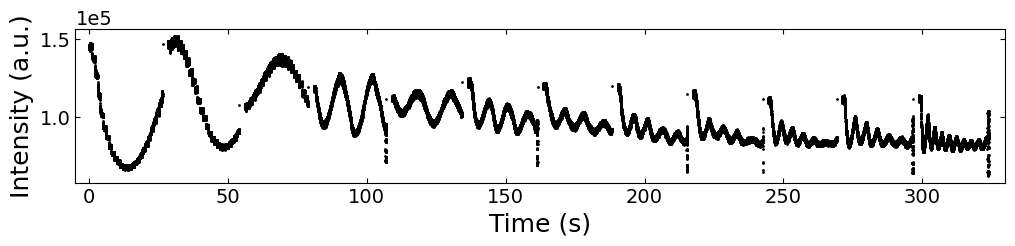

In [4]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 'growth_6':5, 
               'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,330],
           markersize=1, save_path='../figures/3.sample1_intensity.png')

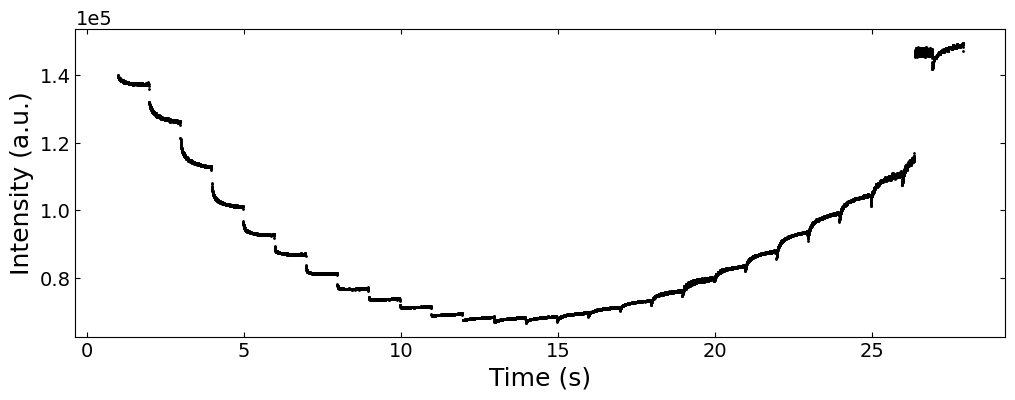

In [62]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=0)
x_sample = x_all[x_all<29]
y_sample = y_all[x_all<29]

x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(15, 3), pca_component=10)

x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          save_path='../figures/3.Test6-First_unit_cell.png')

## 2.2 Treated substrate(step width=0.11±0.01μm)

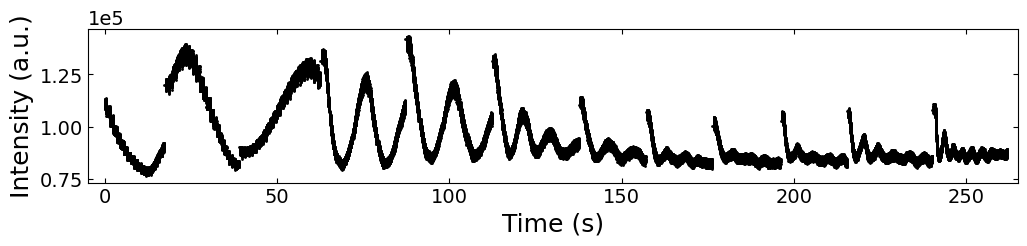

In [6]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 
               'growth_6':5, 'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 
               'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=200)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,265],
           save_path='../figures/3.sample2_intensity.png')           

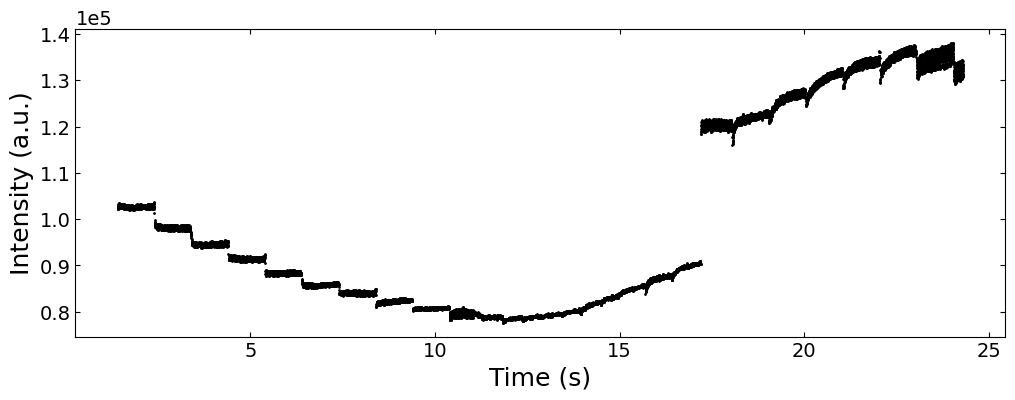

In [61]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
# title = 'Treated substrate(step width=0.43±0.04μm)'
growth_dict = {'growth_1.':1, 'growth_2':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=0)
x_sample = x_all[x_all<25]
y_sample = y_all[x_all<25]

x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(13, 3), pca_component=10)

x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          save_path='../figures/3.Test7-First_unit_cell.png')

## 2.3 Untreated substrate(step width=0.28±0.03μm)

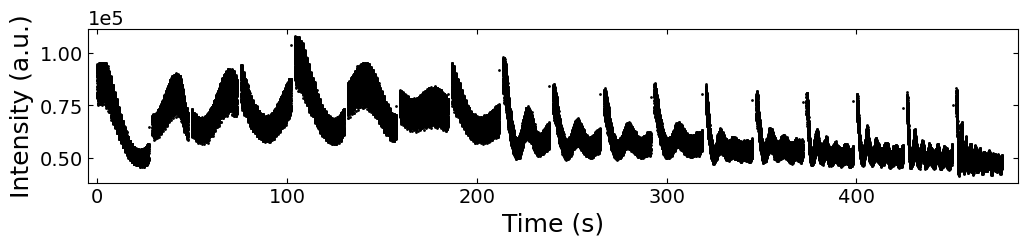

In [114]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_01':1, 'growth_02':1, 'growth_03':1, 'growth_04':1, 'growth_05':1, 
               'growth_06':1, 'growth_07':1, 'growth_08':1, 'growth_09':3, 'growth_10':3, 
               'growth_11':3, 'growth_12':3, 'growth_13':5, 'growth_14':5, 'growth_15':7, 
               'growth_16':7, 'growth_17':9, 'growth_18':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2), xlim=[-5,485],
           save_path='../figures/3.sample3_intensity.png')           

In [30]:
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
def process_rheed_data(xs, ys, length=500, savgol_window_order=(15, 3), pca_component=10):    
    # interpolate the data to same size 
    if length:
        xs_processed = []
        ys_processed = []
        for x, y in zip(xs, ys):
            x_sl = np.linspace(np.min(x), np.max(x), length)
            y_sl = np.interp(x_sl, x, y)
            xs_processed.append(x_sl)
            ys_processed.append(y_sl)
    xs_processed, ys_processed = np.array(xs_processed), np.array(ys_processed)

    # denoise
    if savgol_window_order:
        ys_processed = savgol_filter(ys_processed, savgol_window_order[0], savgol_window_order[1])
    if pca_component:
        pca = PCA(n_components=pca_component)
        ys_processed = pca.inverse_transform(pca.fit_transform(ys_processed))
    return xs_processed, ys_processed

In [20]:
x_sample

array([0.0000e+00, 2.0000e-03, 4.0000e-03, ..., 4.0994e+01, 4.0996e+01,
       4.0998e+01])

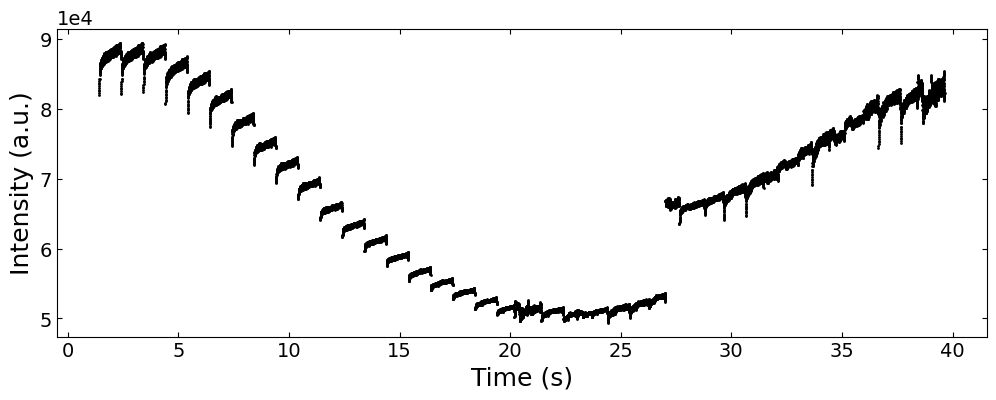

In [45]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
# title = 'Treated substrate(step width=0.43±0.04μm)'
growth_dict = {'growth_01':1, 'growth_02':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', x_start=0, interval=0)
x_sample = x_all[x_all<41]
y_sample = y_all[x_all<41]

x_peaks, xs, ys = detect_peaks(x_sample, y_sample, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
xs, ys = process_rheed_data(xs, ys, length=500, savgol_window_order=(19, 1), pca_component=3)

x_sample, y_sample = np.concatenate(xs), np.concatenate(ys)
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          sav9e_path='../figures/3.Test9-First_unit_cell.png')

In [25]:
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4), 
          save_path='../figures/3.Test9-First_unit_cell.png')

ValueError: object of too small depth for desired array